In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
import glob
import pandas as pd
from keplerdata import Dataset
plt.rcParams['figure.figsize'] = [12,10]
from tqdm import tqdm

In [3]:
datadir = '/Users/davies/Projects/ClusterUp/Data/MNLNGC6791-20180307-231444/output/KASOC_Corrected_timeseries/'
sfiles = glob.glob(datadir + '*.dat')
df = pd.read_csv('/Users/davies/Dropbox/K2_seismo_pipes/NGC6791/Data/NGC6791.csv')
df['EPIC'] = df.KIC
df_out = pd.read_csv('/Users/davies/Projects/KeplerGold/output_NGC6791.csv')
df_out['KIC'] = df_out.ID
df = df.merge(df_out, on='KIC', how='inner')

df = df[df.KIC != 2436097]
df = df[df.KIC != 2436593]
df = df[df.KIC != 2436954]
df = df[df.KIC != 2436759]
df = df[df.KIC != 2437496]

df = df[:7**2]
dss = [Dataset(row.EPIC, glob.glob(datadir + 'kplr*' + str(row.EPIC) + '*.dat')[0]) for idx, row in df.iterrows()]
for ds in tqdm(dss):
    ds.power_spectrum(dfN=(0.01, 28800))
    ds.rebin_quick(100)
power = [ds.smoo_power for ds in dss]
freq = dss[0].smoo_freq

100%|██████████| 49/49 [00:23<00:00,  2.10it/s]


In [4]:
data = np.zeros([len(dss[0].smoo_power), len(dss)])
for idx, p in enumerate(power):
    data[:,idx] = p
freq = freq[2:]
data = data[2:, :]

Text(0,0.5,'Rebinned power')

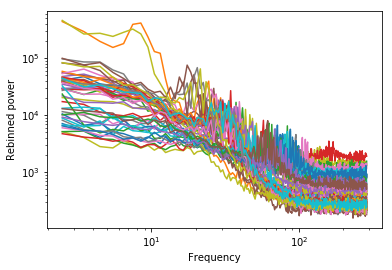

In [5]:
fig, ax = plt.subplots()
for idx, d in enumerate(data[0,:]):
    plt.plot(freq, data[:, idx])
ax.plot(freq, data[:,0])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Frequency')
ax.set_ylabel('Rebinned power')

In [6]:
df.loc[df.KIC == 2436593, 'Numax'] = 28.0
numaxs = df.Numax.values
whites = np.median(data[-3:,:], axis=0)
kics = df.KIC.values

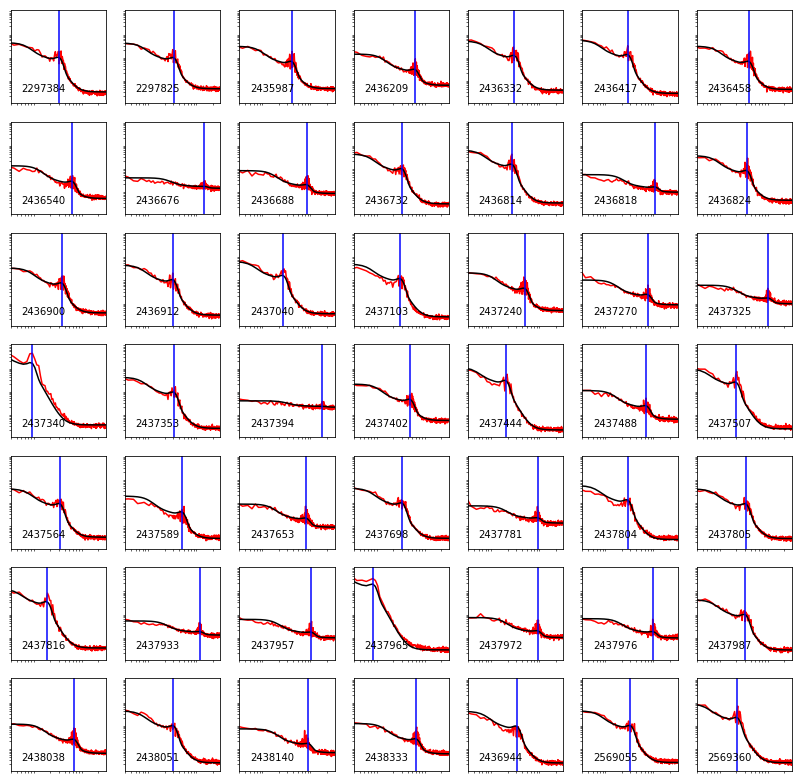

In [7]:
def harvey(f, a, b, c=4.0):
    return 0.9*a**2/b/(1 + (f/b)**c)
def gaussian(f, numax, width, height):
    return height * np.exp(-0.5 * (f - numax)**2 / width**2)
def apod(f, nyq):
    x = f / 2.0 / nyq
    
    return np.sinc(x)**2
def model(f, ak, ae, bk, be, ck, ce, dk, de, numax, wk, we, hk, he, white):
    a = 10**(ak + numax*ae)
    b = 10**(bk + numax*be)
    c = 10**(ck + numax*ce)
    d = 10**(dk + numax*de)
    width = 10**(wk + numax*we)
    height = 10**(hk + numax*he)
    model = (apod(f, 288.8) * (harvey(f, a, b) + harvey(f, c, d) + gaussian(f, 10**numax, width, height))) + 10**white
    return model
ak, ae = 3.4, -0.48
bk, be = -0.43, 0.86
ck, ce = 3.59, -0.59
dk, de = 0.02, 0.96
wk, we = -0.82, 1.03
hk, he = 6.95, -2.18
n = 7
fig, ax = plt.subplots(n,n, figsize=[14, 14])
for i in range(0, n*n):
    x = i // n
    y = i % n
    fit0 = model(freq, 
                 ak, ae, bk, be, 
                 ck, ce, dk, de, np.log10(numaxs[i]), 
                 wk, we, hk, he, 
                 np.log10(whites[i]))
    ax[x, y].plot(freq, data[:,i], 'r-')
    ax[x, y].plot(freq, fit0, 'k-')
    ax[x, y].set_xscale('log')
    ax[x, y].set_yscale('log')
    ax[x, y].set_ylim([1e2, 1e6])
    ax[x, y].set_xlim([3 ,288])
    ax[x, y].axvline(numaxs[i], c='b')
    ax[x, y].set_yticks([])
    ax[x, y].set_xticks([])
    ax[x, y].text(5, 3e2, str(kics[i]))

Text(0,0.5,'Log White Noise')

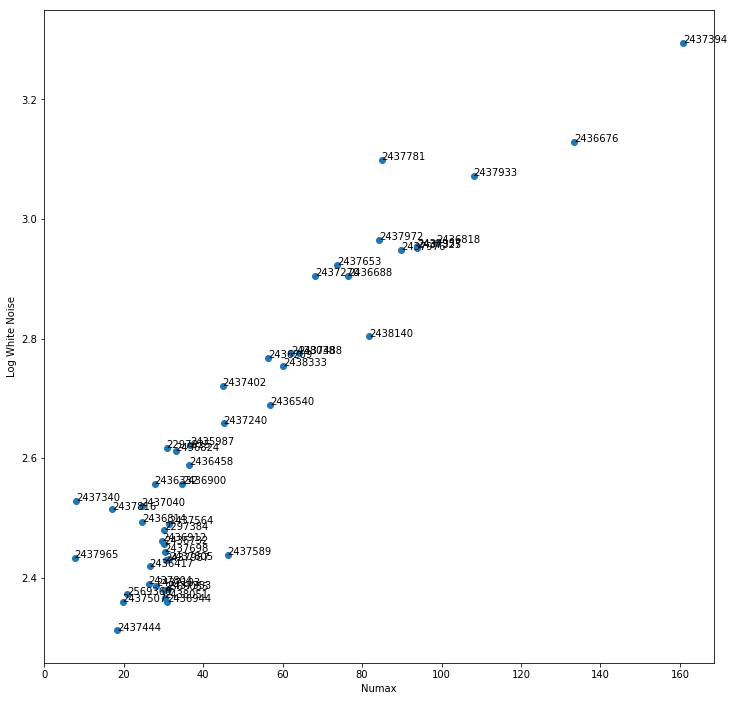

In [8]:
fig, ax = plt.subplots(figsize=[12,12])
ax.scatter(numaxs, np.log10(whites))
for i in range(len(kics)):
    ax.text(numaxs[i], np.log10(whites[i]), str(kics[i]))
ax.set_xlabel('Numax')
ax.set_ylabel('Log White Noise')

The gamma function in stan is parameterised in a way I'm not used to (wiki says the stan way is common in Bayesian stats).  Let's investigate.

${\rm Gamma}(\alpha, \beta) = \frac{\beta^{\alpha}}{\Gamma(\alpha)} x^{\alpha - 1} e^{-\beta x}$.

This parameterisation gives a mean value $\frac{\alpha }{\beta}$ and a variance of $\frac{\alpha}{\beta^{2}}$.  $\alpha$ is called the shape and $\beta$ is called the rate.

$\alpha$ is the same parameter as the shape $k$ in my familiar notation.  The rate $\beta$ is then the recipricol of the scale, i.e., $\theta = \frac{1}{\beta}$.

When fitting a power spectrum the data are the model multiplied by the noise distribution.  If we calculate the data divided by the model we are left with the noise distirbution.  

In [31]:
code = '''
functions {
    real harvey(real f, real a, real b, real c){
        return 0.9*a^2/b/(1.0 + (f/b)^c);
    }
    real gaussian(real f, real numax, real width, real height){
        return height * exp(-0.5 * (f - numax)^2 / width^2);
    }
    real apod(real f, real nyq){
        real x = 3.14 / 2.0 * f / nyq;
        return (sin(x) / x)^2;
    }
}
data {
    int N;
    int M;
    int dof;
    vector[N] f;
    real p[N, M];
    vector[M] numax_est;
    vector[M] white_est;

}
parameters {
    real<lower = 0> numax_std[M];
    real<lower = 0> numaxspread;
    real<lower = 0> white_std[M];
    real<lower = 0> whitespread;
    real a_std[M];
    real<lower = 0> aspread;
    real b_std[M];
    real<lower = 0> bspread;
    real c_std[M];
    real<lower = 0> cspread;
    real d_std[M];
    real<lower = 0> dspread;
    real w_std[M];
    real<lower = 0> wspread;
    real h_std[M];
    real<lower = 0> hspread;
    real ae;
    real be;
    real ce;
    real de;
    real ak;
    real bk;
    real ck;
    real dk;
    real wk;
    real we;
    real hk;
    real he; 
}
transformed parameters {
    vector[M] a;
    vector[M] b;
    vector[M] c;
    vector[M] d;
    vector[M] w;
    vector[M] h;
    real numax[M];
    real white[M];
    for (j in 1:M){
        numax[j] = numax_std[j] * numaxspread + numax_est[j];
        white[j] = white_std[j] * whitespread + white_est[j];
        a[j] = 10^((ak + numax[j] * ae) + a_std[j] * aspread);
        b[j] = 10^((bk + (numax[j]) * be) + b_std[j] * bspread);
        c[j] = 10^((ck + (numax[j]) * ce)  + c_std[j] * cspread);
        d[j] = 10^((dk + (numax[j]) * de) + d_std[j] * dspread);
        w[j] = 10^((wk + (numax[j]) * we) + w_std[j] * wspread);
        h[j] = 10^((hk + (numax[j]) * he) + h_std[j] * hspread);
    }
}
model {
    real beta[N, M];
    for (j in 1:M){
        for (i in 1:N){
            beta[i, j] = dof / (apod(f[i], 288.8)
                        * (harvey(f[i], a[j], b[j], 4.0)
                        + harvey(f[i], c[j], d[j], 4.0)
                        + gaussian(f[i], 10^numax[j], w[j], h[j]))
                        + 10^white[j]);
        }
        p[1:N, j] ~ gamma(dof, beta[1:N, j]);
    }
    ak ~ normal(3.45, 0.03); // log 10
    ae ~ normal(-0.48, 0.001);
    aspread ~ normal(0.0, 0.0001); // log 10
    a_std ~ normal(0, 1);
    bk ~ normal(-0.46, 0.001); //log10
    be ~ normal(0.89, 0.001);
    bspread ~ normal(0.0, 0.001);
    b_std ~ normal(0, 1);
    ck ~ normal(3.59, 0.001); // log10
    ce ~ normal(-0.61, 0.001);
    cspread ~ normal(0.0, 0.001);
    c_std ~ normal(0, 1);
    dk ~ normal(0.04, 0.001); //log10
    de ~ normal(0.95, 0.001);
    dspread ~ normal(0.0, 0.001);
    d_std ~ normal(0, 1);
    wk ~ normal(-0.83, 0.001); // log10
    we ~ normal(1.0, 0.001);
    wspread ~ normal(0.0, 0.001);
    w_std ~ normal(0, 1);
    hk ~ normal(6.93, 0.001); // log10
    he ~ normal(-2.18, 0.001);
    hspread ~ normal(0.0, 0.001);
    h_std ~ normal(0, 1);
    numaxspread ~ normal(0.0, 0.001);
    numax ~ normal(0, 1);
    white_std ~ normal(0, 1);
    whitespread ~ normal(0, 0.001);
}
'''
sm = pystan.StanModel(model_code=code, model_name='backfit')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL backfit_4d8c81a609b10719fd1f5befd9b21a32 NOW.


In [24]:
dat = {'N': len(freq),
       'M': len(numaxs),
       'dof': 100,
      'f': freq,
      'p': data,
      'numax_est': np.log10(numaxs),
      'white_est': np.log10(whites)}
# Note dof is not actually dof but is in fact the number of bins over which we have smoothed.
fit = sm.sampling(data=dat, iter=100, chains=1)

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Inference for Stan model: backfit_4d6f869e205c169a81ea76e0e812c592.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
numax_std[0]    0.16  5.5e-3 9.5e-3   0.15   0.15   0.16   0.17   0.18      3   2.07
numax_std[1]    1.47    0.05   0.12   1.27   1.36   1.49   1.57   1.68      6   1.16
numax_std[2]    0.63    0.02   0.06   0.53   0.57   0.63   0.68   0.74      9    1.0
numax_std[3]    0.82    0.02   0.04   0.71   0.79   0.83   0.84   0.88      6   1.25
numax_std[4]    0.18  9.8e-3   0.02   0.15   0.16   0.17   0.19   0.23      4   1.47
numax_std[5]     1.6    0.09    0.2    1.4   1.48   1.53   1.66   2.22      5   1.48
numax_std[6]    2.16    0.15   0.25   1.77   1.96   2.15   2.42   2.61      3   1.58
numax_std[7]    3.74    0.28   0.69   2.63   3.24   3.65   4.21   5.22      6   1.37
numax_std[8]    10.1    2.27   3.93   4.27   6.34   

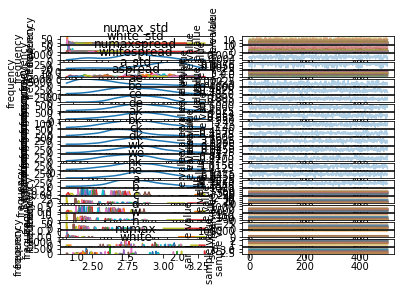

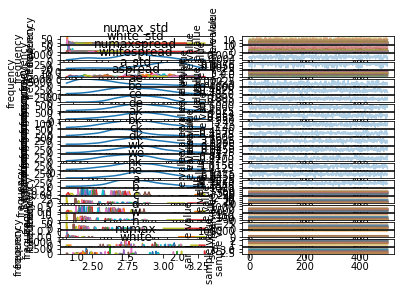

In [25]:
print(fit)
fit.plot()

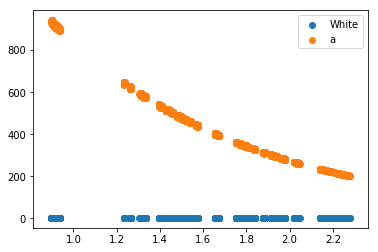

In [29]:
fig, ax = plt.subplots()
ax.scatter(fit['numax'], fit['white'], label='White')
ax.scatter(fit['numax'], fit['a'], label='a')
ax.legend()

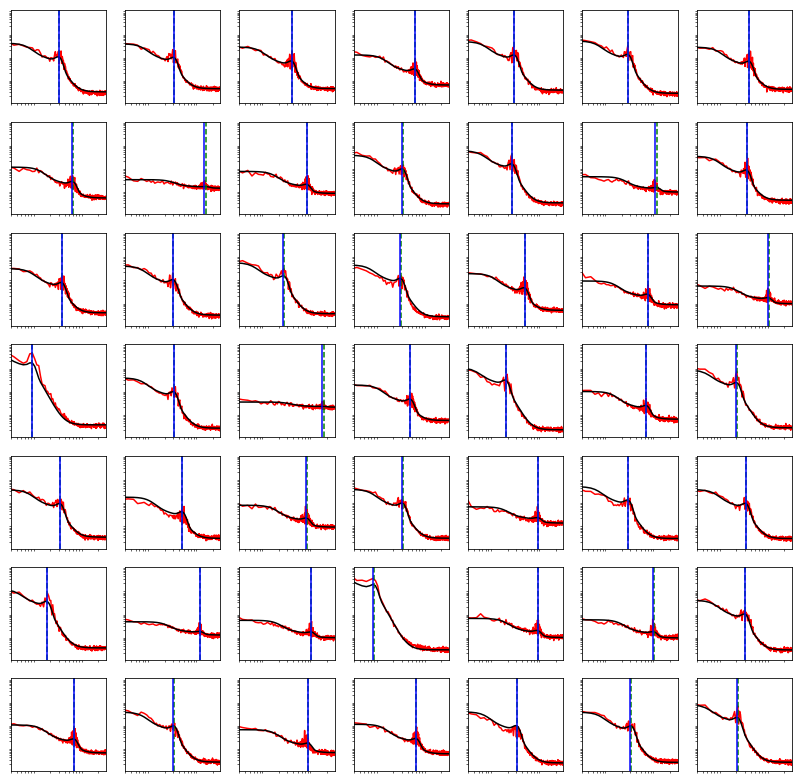

In [30]:
n = 7
fig, ax = plt.subplots(n,n, figsize=[14, 14])
ak = fit['ak'].mean()
ae = fit['ae'].mean()
bk = fit['bk'].mean()
be = fit['be'].mean()
ck = fit['ck'].mean()
ce = fit['ce'].mean()
dk = fit['dk'].mean()
de = fit['de'].mean()
wk = fit['wk'].mean()
we = fit['we'].mean()
hk = fit['hk'].mean()
he = fit['he'].mean()
numax = fit['numax'].mean(axis=0)
white = fit['white'].mean(axis=0)
for i in range(0, n*n):
    fit0 = model(freq, ak, ae, bk, be, ck, ce, dk, de, numax[i], wk, we, hk, he, white[i])
    x = i // n
    y = i % n
    ax[x, y].plot(freq, data[:,i], 'r-')
    ax[x, y].plot(freq, fit0, 'k-')
    ax[x, y].set_xscale('log')
    ax[x, y].set_yscale('log')
    ax[x, y].set_ylim([1e2, 1e6])
    ax[x, y].set_xlim([3 ,288])
    ax[x, y].axvline(10**numax[i], c='g', linestyle='--')
    ax[x, y].axvline(numaxs[i], c='b')
    ax[x, y].set_yticks([])
    ax[x, y].set_xticks([])

In [28]:
print(np.median(10**fit['numax'], axis=0))
print(np.std(10**fit['numax'], axis=0))

[ 30.30144454  31.27992235  37.05125395  56.76995196  27.85205764
  26.94516725  37.30527285  59.07440956 146.87952989  76.63768678
  31.30504436  24.86256505 107.66152132  33.14873067  34.82413528
  30.39548911  25.5298718   28.67397586  45.27334009  69.04214302
  94.04278731   8.30641782  31.24918521 175.63284995  45.54702876
  18.35854651  64.80754982  20.59869077  32.11955586  46.981229
  75.54078141  31.33866091  86.45800362  27.16575678  31.69044382
  17.16857664 108.82361785  95.13711675   7.96828775  84.67976951
  91.72449977  30.63914472  62.61881586  31.39901626  81.86798043
  60.27388944  30.96803635  31.54963356  21.39019895]
[3.48180554e-03 5.69662351e-02 3.20457469e-02 5.16796274e-02
 8.44534147e-03 8.55335686e-02 1.34956598e-01 3.25729356e-01
 6.73324980e+00 4.97020238e-02 9.61957226e-02 2.86348108e-02
 1.22622021e+00 7.71672387e-03 1.89366124e-02 6.35938293e-02
 8.14287149e-02 1.25617136e-01 1.81795530e-02 2.11208216e-01
 3.29667243e-02 1.21007139e-01 4.47108000e-02 5.7